In [1]:
import torch
from torch.utils.data import DataLoader
from pprint import pprint
import matplotlib.pyplot as plt

from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

pt.update_plot_defaults()

In [2]:
input_size = 21
dataset = torch.eye(input_size) #each row is a different pattern
target = torch.eye(dataset.shape[0])

data_seed = 0
data_generator = torch.Generator()
sample_indexes = torch.arange(len(dataset))
dataloader = DataLoader(list(zip(sample_indexes, dataset, target)), 
                        shuffle=True, 
                        generator=data_generator)

test_dataloader = DataLoader(list(zip(sample_indexes, dataset, target)), 
                             batch_size = 21)
epochs=30
seed=42

### BTSP learning rule

In [3]:
network_config = ut.read_from_yaml('../config/loss_landscape_analysis/20221104_EIANN_1_hidden_BTSP_config_B.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

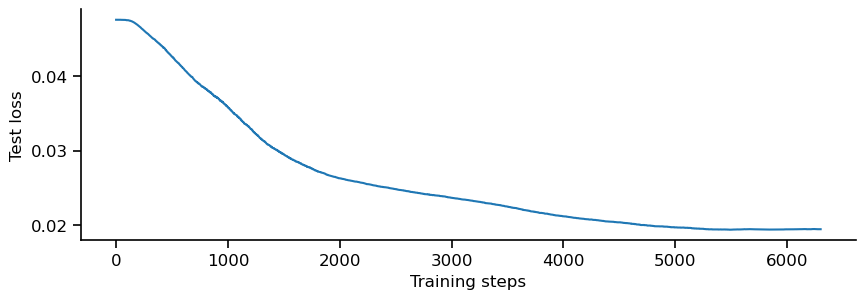

In [4]:
data_generator.manual_seed(data_seed)
btsp_network.train(dataloader, epochs, store_history=True, store_weights=True, status_bar=True)

pt.plot_test_loss_history(btsp_network, test_dataloader)

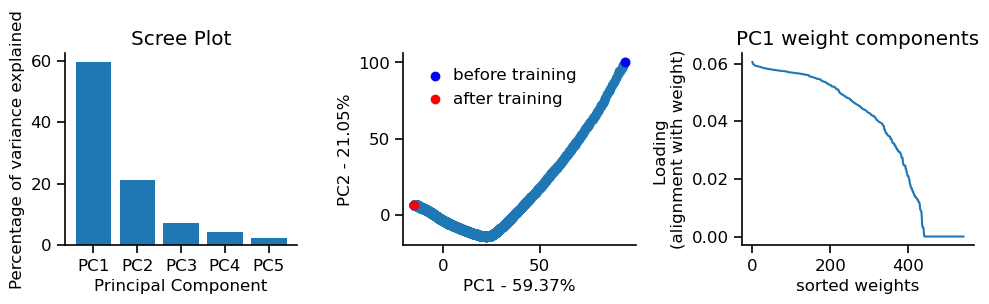

In [5]:
flat_param_history_btsp,_ = pt.get_flat_param_history(btsp_network.param_history)
pt.plot_param_history_PCs(flat_param_history_btsp)

  0%|          | 0/400 [00:00<?, ?it/s]

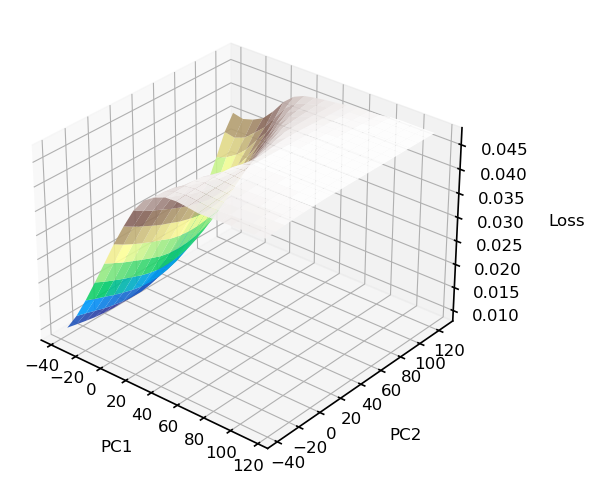

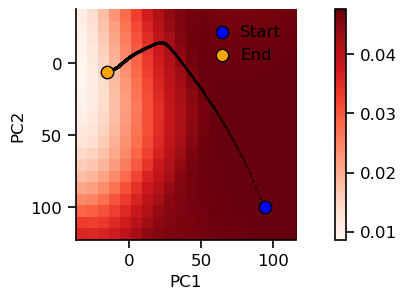

In [6]:
pt.plot_loss_landscape(test_dataloader, btsp_network, num_points=20)

In [7]:
ut.compute_sparsity_history(btsp_network)
pt.plot_sparsity_history(btsp_network)

IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

### Backprop (softplus; SGD)

In [ ]:
network_config = ut.read_from_yaml('../config/loss_landscape_analysis/EIANN_1_hidden_vanilla_backprop_softplus_SGD_config.yaml')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

In [ ]:
# Initialize backprop net with same weights as BTSP init
btsp_initial_state = btsp_network.param_history[0]
btsp_initial_state = {key: btsp_initial_state[key] for key in bp_network.state_dict()}
bp_network.load_state_dict(btsp_initial_state)

In [ ]:
data_generator.manual_seed(data_seed)
bp_network.train(dataloader, epochs, store_history=True, store_weights=True, status_bar=True)

#Swap to ReLU activation to make loss comparable across networks
for layer in bp_network: 
    for population in layer:
        population.activation = torch.nn.ReLU()

pt.plot_test_loss_history(bp_network, test_dataloader)

In [ ]:
flat_param_history_bp,_ = pt.get_flat_param_history(bp_network.param_history)
pt.plot_param_history_PCs(flat_param_history_bp)

In [ ]:
pt.plot_loss_landscape(test_dataloader, bp_network, num_points=20)

In [ ]:
pt.plot_network_dynamics(bp_network)

In [ ]:
ut.compute_sparsity_history(bp_network)
pt.plot_sparsity_history(bp_network)

## Combined loss landscape


In [ ]:
# Remove BTSP-specific parameters (Dend_I)
bp_dict_keys = bp_network.state_dict().keys()
for i,state_dict in enumerate(btsp_network.param_history):
    state_dict_subset = {key: state_dict[key] for key in bp_dict_keys}
    btsp_network.param_history[i] = state_dict_subset

In [ ]:
flat_param_history1,_ = pt.get_flat_param_history(btsp_network.param_history)
flat_param_history2,_ = pt.get_flat_param_history(bp_network.param_history)
combined_param_history = torch.cat([flat_param_history1,flat_param_history2])
pt.plot_param_history_PCs(combined_param_history)

In [ ]:
btsp_network.name = 'BTSP'
bp_network.name = 'Backprop'
pt.plot_loss_landscape(test_dataloader, bp_network, btsp_network, num_points=40, extension=0.5)